In [1]:
import requests
import json
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import LSTM, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'
df = df.drop(['conversionType', 'conversionSymbol'], 1)

In [3]:
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-12-02,363.43,347.16,361.80,92449.73,3.288109e+07,359.98
2015-12-03,371.37,355.47,359.98,87225.21,3.167328e+07,360.31
2015-12-04,363.95,354.31,360.31,60548.44,2.182061e+07,361.67
2015-12-05,390.28,361.50,361.67,115198.52,4.343810e+07,386.69
2015-12-06,402.19,382.62,386.69,131856.64,5.206858e+07,393.38
...,...,...,...,...,...,...
2021-05-20,42520.03,35009.25,36771.87,139648.53,5.531455e+09,40597.40
2021-05-21,42252.07,33552.80,40597.40,120589.87,4.573693e+09,37350.39
2021-05-22,38841.92,35287.71,37350.39,74964.98,2.808008e+09,37491.50


In [4]:
#split training validation
# training_size = int(0.8* datas.shape[0])
# training_datas = datas[:training_size,:]
# training_labels = labels[:training_size,:,0]
# validation_datas = datas[training_size:,:]
# validation_labels = labels[training_size:,:,0]

def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(df, test_size=0.2)

In [5]:
train.shape

(1601, 6)

In [6]:
test.shape

(400, 6)

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

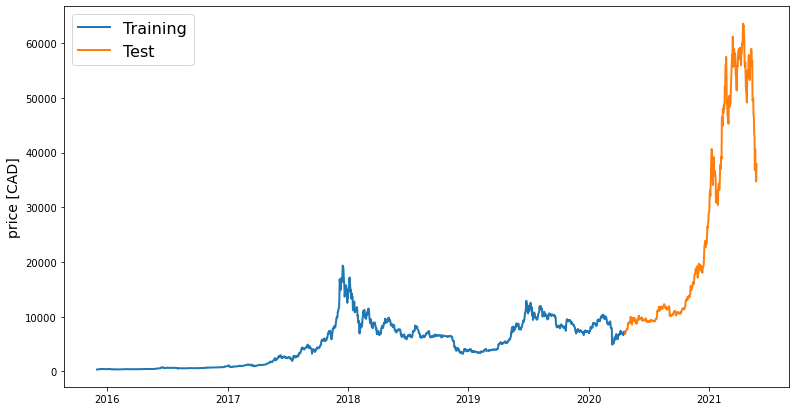

In [8]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [9]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [10]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    
    return np.array(window_data)

In [11]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [12]:
window_len = 5
zero_base = True
test_size = 0.2
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [13]:
np.random.seed(42)
output_size=1
lstm_neurons = 100
epochs = 300
batch_size = 32
activ_func='relu'
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [14]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [15]:
model = Sequential()
model.add(LSTM(lstm_neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(Dense(units=output_size))
model.add(Activation(activ_func))
model.compile(loss=loss, optimizer=optimizer)

In [16]:
#build model
# model = Sequential()
# model.add(LSTM(units=units, activity_regularizer=regularizers.l1(reg), input_shape=(step_size,nb_features),return_sequences=False))
# model.add(Activation('tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(output_size))
# model.add(LeakyReLU())
# model.compile(loss='mse', optimizer='adam')
# model.fit(training_datas, training_labels, batch_size=batch_size,validation_data=(validation_datas,validation_labels), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True)])

In [17]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Train on 1596 samples
Epoch 1/300
1596/1596 [==============================] - 0s 76us/sample - loss: 0.0087
Epoch 2/300
1596/1596 [==============================] - 0s 74us/sample - loss: 0.0086
Epoch 3/300
1596/1596 [==============================] - 0s 76us/sample - loss: 0.0086
Epoch 4/300
1596/1596 [==============================] - 0s 76us/sample - loss: 0.0086
Epoch 5/300
1596/1596 [==============================] - 0s 74us/sample - loss: 0.0086
Epoch 6/300
1596/1596 [==============================] - 0s 75us/sample - loss: 0.0086
Epoch 7/300
1596/1596 [==============================] - 0s 73us/sample - loss: 0.0086
Epoch 8/300
1596/1596 [==============================] - 0s 73us/sample - loss: 0.0086
Epoch 9/300
1596/1596 [==============================] - 0s 73us/sample - loss: 0.0086
Epoch 10/300
1596/1596 [==============================] - 0s 72us/sample - loss: 0.0086
Epoch 11/300
1596/1596 [==============================] - 0s 73us/sample - loss: 0.0086
Epoch 12/300
1596/1

In [18]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


0.0406358462325815

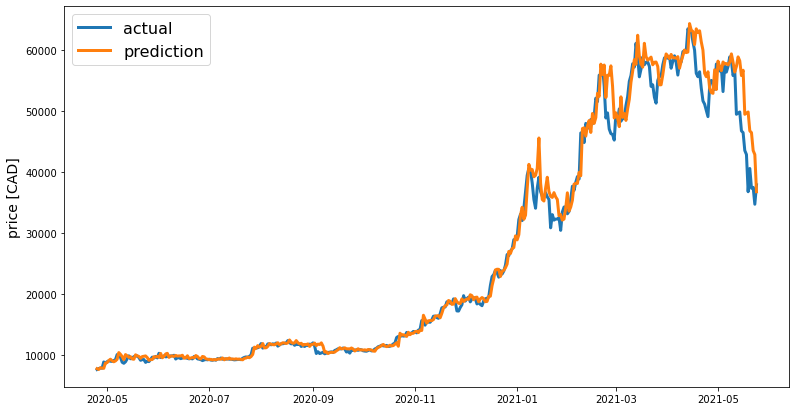

In [19]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)